## Лабораторная работа №4  
ФИО: Брызгалова Юлия Александровна  
Группа: БИВТ-21-4

Исходные данные:
Название датасета: Medical Cost Personal Datasets  
Ссылка на датасет: https://www.kaggle.com/datasets/mirichoi0218/insurance

Ход работы:
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
&nbsp; A. Разделить выборку на тренировочную (train) и тестовую (test). Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test.  
&nbsp; B. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.  
&nbsp; C. Отнормировать численные переменные (StandardScaler, MinMaxScaler).  
&nbsp; D. Закодировать категориальные признаки по одной из стратегий.  
4. Оформить данные в виде класса Dataset из библиотеки torch (как на семинаре), а затем засунуть в Dataloader (как на семинаре).  
5. Обучить на тренировочном множестве:  
&nbsp; A. Очень простую однослойную нейросеть с оптимизатором SGD.
&nbsp; B. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором Adam.
&nbsp; C. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором Adam.
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки matplotlib (выйдет так называемая learning curve, кривая обучения модели).
7. Посчитайте метрики на train и test множествах:
&nbsp; A. Для задачи классификации -- Accuracy
&nbsp; B. Для задачи регрессии -- MAE
8. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:  
&nbsp; A. Какая модель справилась лучше с поставленной задачей?  
&nbsp; B. Имеет ли место переобучение?  
&nbsp; C. Имеет ли место недообучение?  
&nbsp; D. Как можно улучшить метрики моделей?

Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

1. Импорт данных



In [ ]:
data = pd.read_csv('/content/insurance.csv', sep = ',')  # если нужно, можно поменять разделитель

2. Задача регрессии - прогнозирование цен на медицинское страхование

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


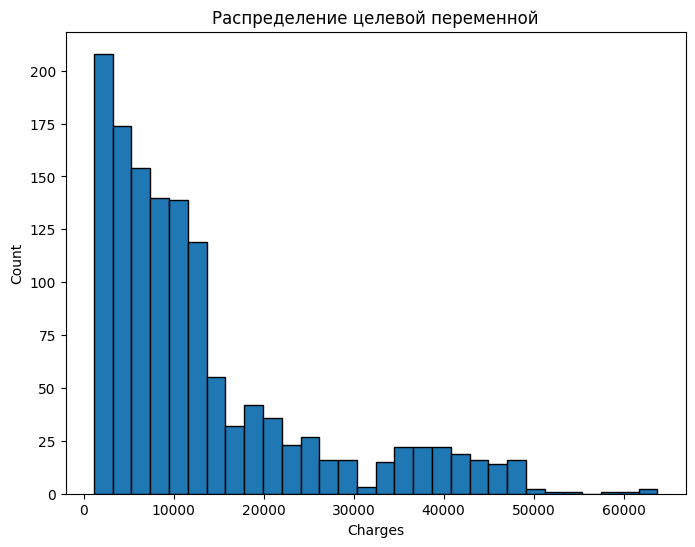

Количество уникальных значений целевой переменной: 1337


charges
1639.56310     2
16884.92400    1
29330.98315    1
2221.56445     1
19798.05455    1
              ..
7345.08400     1
26109.32905    1
28287.89766    1
1149.39590     1
29141.36030    1
Name: count, Length: 1337, dtype: int64

In [ ]:
# Построение распределения charges - целевой переменной в виде гистограммы
plt.figure(figsize = (8, 6))
plt.hist(data['charges'], edgecolor = 'black', bins = 30)
plt.title('Распределение целевой переменной')
plt.xlabel('Charges')
plt.ylabel('Count')
plt.show()

# Количество уникальных значений целевой переменной
# nunique() - функция, вычисляющая кол-во уникальных записей
unique_charges = data['charges'].nunique()
print(f'Количество уникальных значений целевой переменной: {unique_charges}')
data['charges'].unique()
# value_counts() - функция, возвращающая частоту встречающихся значений
data['charges'].value_counts()

3. Предобработка данных

A. Деление выборки на train и test множества

In [ ]:
# Деление выборки на train и test
from sklearn.model_selection import train_test_split

X = data.drop('charges', axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


B. Проверка пропусков в данных  
**Данные полные*

In [ ]:
# Пропуски данных
print(f"Пропущенные значения в данных: {X_train.isnull().sum().sum()}")
print(f"Пропущенные значения в данных: {y_train.isnull().sum().sum()}")

Пропущенные значения в данных: 0
Пропущенные значения в данных: 0


C. Отнормировать численные переменные (StandartScaler)

In [ ]:
# Отнормировать численные переменные
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[['age', 'bmi', 'children']] = scaler.fit_transform(X_train[['age', 'bmi', 'children']])
X_test[['age', 'bmi', 'children']] = scaler.transform(X_test[['age', 'bmi', 'children']])


D. Закодировать категориальные признаки (LabelEncoder)



In [ ]:
# Закодировать категориальные признаки
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
X_train['sex'] = encoder.fit_transform(X_train['sex'])
X_test['sex'] = encoder.transform(X_test['sex'])
X_train['smoker'] = encoder.fit_transform(X_train['smoker'])
X_test['smoker'] = encoder.transform(X_test['smoker'])
X_train['region'] = encoder.fit_transform(X_train['region'])
X_test['region'] = encoder.transform(X_test['region'])

4. Оформить данные в виде класса Dataset из библиотеки torch, затем засунуть в Dataloader (как на семинаре)

In [ ]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(f"Using {device} device")

Using cpu device


In [ ]:
# Создание Dataset и DataLoader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class MedicalCostPersonalDatasets(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X_train.values, dtype=torch.float32)
    self.y = torch.tensor(y_train.values, dtype=torch.float32)
  def __len__(self):
    return len(self.X)
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

train_dataset = MedicalCostPersonalDatasets(X_train, y_train)
test_dataset = MedicalCostPersonalDatasets(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


5. Обучение на тренировочном множестве
* A. Однослойная нейросеть с оптимизатором SGD

In [ ]:
# 5. Обучение модели на тренировочном множестве
# а) Однослойная нейросеть с оптимизатором SGD

class SingleNetwork(nn.Module):
  def __init__(self):
    super(SingleNetwork, self).__init__()
    self.fc = nn.Linear(X_train.shape[1], 1)

  def forward(self, x):
    x = self.fc(x)
    return x

model = SingleNetwork()
print(model)

SingleNetwork(
  (fc): Linear(in_features=6, out_features=1, bias=True)
)


6. Посчитать loss на train и test множествах, в зависимости от эпохи
* A. Однослойная нейросеть с оптимизатором SGD

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1, Loss_train: 13290.6815, Loss_test: 13339.4656
Epoch 2, Loss_train: 13321.0645, Loss_test: 13339.4046
Epoch 3, Loss_train: 13353.3227, Loss_test: 13339.3437
Epoch 4, Loss_train: 13311.5997, Loss_test: 13339.2832
Epoch 5, Loss_train: 13362.9493, Loss_test: 13339.2224
Epoch 6, Loss_train: 13321.5816, Loss_test: 13339.1613
Epoch 7, Loss_train: 13367.0210, Loss_test: 13339.1008
Epoch 8, Loss_train: 13371.0755, Loss_test: 13339.0398
Epoch 9, Loss_train: 13391.7069, Loss_test: 13338.9793
Epoch 10, Loss_train: 13357.5215, Loss_test: 13338.9184
Epoch 11, Loss_train: 13330.1132, Loss_test: 13338.8575
Epoch 12, Loss_train: 13388.0592, Loss_test: 13338.7972
Epoch 13, Loss_train: 13372.0875, Loss_test: 13338.7363
Epoch 14, Loss_train: 13315.8504, Loss_test: 13338.6754
Epoch 15, Loss_train: 13321.4983, Loss_test: 13338.6147
Epoch 16, Loss_train: 13331.9886, Loss_test: 13338.5543
Epoch 17, Loss_train: 13316.6414, Loss_test: 13338.4932
Epoch 18, Loss_train: 13355.2943, Loss_test: 13338.4326
E

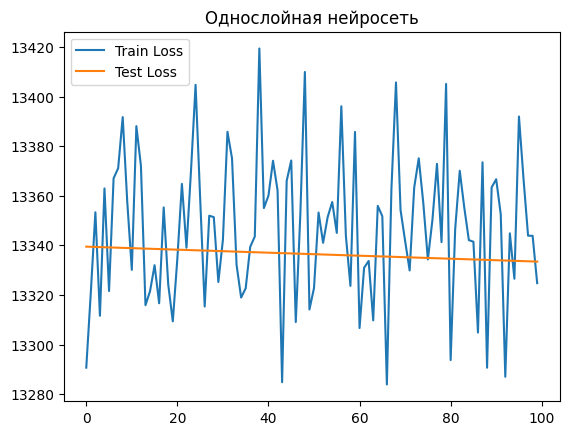

In [ ]:
# Вычислить Loss на trai и test множествах, в зависимости от эпохи обучения - learning curve
# а) Однослойная нейросеть с оптимизатором SGD

model = SingleNetwork()
# MAE loss
criterion = nn.L1Loss()
epoch = 100
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

train_losses, test_losses = [], []

for i in range(epoch):
  train_loss = 0.0
  for X_train, y_train in train_dataloader:
    model.train()
    # Зануляем градиенты
    optimizer.zero_grad()
    # Считаем предсказание
    outputs = model(X_train)
    # Считаем лосс
    loss = criterion(outputs, y_train)
    # Прокидываем градиенты
    loss.backward()
    # Делаем шаг оптимизатором
    optimizer.step()
    train_loss += loss.item()
  test_loss = 0.0
  for X_test, y_test in test_dataloader:
    model.eval()
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    test_loss += loss.item()
  print(f"Epoch {i+1}, Loss_train: {train_loss / len(train_dataloader):.4f}, Loss_test: {test_loss / len(test_dataloader):.4f}")
  train_losses.append(train_loss / len(train_dataloader))
  test_losses.append(test_loss / len(test_dataloader))

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Однослойная нейросеть')
plt.legend()
plt.show()

7. Посчитать метрики на train и test множествах: для задачи регрессии -- MAE
* A. Однослойная нейросеть с оптимизатором SGD

In [ ]:
# Посчитать метрики на train и test множествах
# а) Однослойная нейросеть с оптимизатором SGD
from sklearn.metrics import mean_absolute_error

model = SingleNetwork()
def evaluate_model(model, loader):
    model.eval()
    true_values = []
    pred_values = []
    with torch.no_grad():
        for X_train, y_train in train_dataloader:
            pred = model(X_train)
            true_values.extend(y_train.numpy())
            pred_values.extend(pred.numpy().flatten())
    mae = mean_absolute_error(true_values, pred_values)
    return mae

train_mae = evaluate_model(model, train_dataloader)
test_mae = evaluate_model(model, test_dataloader)
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train MAE: 13346.3164
Test MAE: 13346.3164


5. Обучение на тренировочном множестве
* B. Нейросеть с 1 скрытым слоем и оптимизатором Adam

In [ ]:
# 5. Обучение моделей
# б) Нейросеть с одним скрытым слоем с оптимизатором Adam

class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.fc1 = nn.Linear(X_train.shape[1], 64)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(64, 1)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


6. Посчитать loss на train и test множествах, в зависимости от эпохи
* B. Нейросеть с 1 скрытым слоем и оптимизатором Adam

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1, Loss_train: 13397.3234, Loss_test: 13338.8226
Epoch 2, Loss_train: 13300.0179, Loss_test: 13338.3440
Epoch 3, Loss_train: 13387.5129, Loss_test: 13337.7967
Epoch 4, Loss_train: 13380.5541, Loss_test: 13337.1443
Epoch 5, Loss_train: 13325.9569, Loss_test: 13336.3555
Epoch 6, Loss_train: 13360.4779, Loss_test: 13335.4061
Epoch 7, Loss_train: 13295.3417, Loss_test: 13334.2565
Epoch 8, Loss_train: 13324.9933, Loss_test: 13332.8891
Epoch 9, Loss_train: 13347.0790, Loss_test: 13331.2674
Epoch 10, Loss_train: 13366.1434, Loss_test: 13329.3709
Epoch 11, Loss_train: 13323.7552, Loss_test: 13327.1581
Epoch 12, Loss_train: 13320.7291, Loss_test: 13324.6391
Epoch 13, Loss_train: 13336.3693, Loss_test: 13321.7797
Epoch 14, Loss_train: 13338.5473, Loss_test: 13318.5728
Epoch 15, Loss_train: 13361.3604, Loss_test: 13315.0026
Epoch 16, Loss_train: 13309.8917, Loss_test: 13311.0443
Epoch 17, Loss_train: 13319.5022, Loss_test: 13306.6641
Epoch 18, Loss_train: 13345.3940, Loss_test: 13301.9055
E

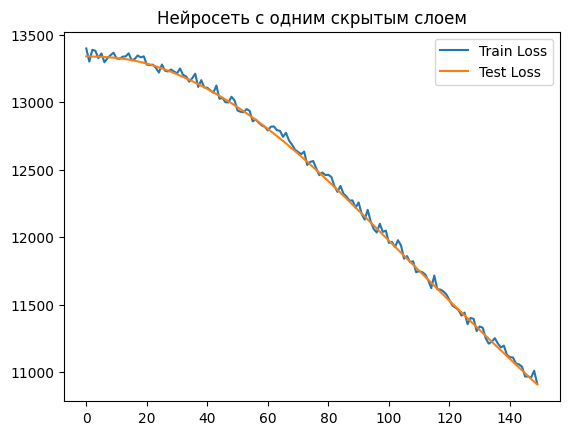

In [ ]:
# Вычислить Loss на trai и test множествах, в зависимости от эпохи обучения - learning curve
# б) Нейросеть с одним скрытым слоем с оптимизатором Adam
import torch

model = NeuralNetwork()
# MAE loss
criterion = nn.L1Loss()
epoch = 150
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, test_losses = [], []

for i in range(epoch):
  train_loss = 0.0
  for X_train, y_train in train_dataloader:
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  test_loss = 0.0
  for X_test, y_test in test_dataloader:
    model.eval()
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    test_loss += loss.item()
  print(f"Epoch {i+1}, Loss_train: {train_loss / len(train_dataloader):.4f}, Loss_test: {test_loss / len(test_dataloader):.4f}")
  train_losses.append(train_loss / len(train_dataloader))
  test_losses.append(test_loss / len(test_dataloader))

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Нейросеть с одним скрытым слоем')
plt.legend()
plt.show()

7. Посчитать метрики на train и test множествах: для задачи регрессии -- MAE
* B. Нейросеть с 1 скрытым слоем и оптимизатором Adam

In [ ]:
# Посчитать метрики на train и test множествах
# б) Нейросеть с одним скрытым слоем
from sklearn.metrics import mean_absolute_error

model = NeuralNetwork()
def evaluate_model(model, loader):
  model.eval()
  true_values = []
  pred_values = []
  with torch.no_grad():
    for X_train, y_train in train_dataloader:
      pred = model(X_train)
      true_values.extend(y_train.numpy())
      pred_values.extend(pred.numpy().flatten())
    mae = mean_absolute_error(true_values, pred_values)
    return mae

train_mae = evaluate_model(model, train_dataloader)
test_mae = evaluate_model(model, test_dataloader)
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train MAE: 13345.9453
Test MAE: 13345.9443


5. Обучение на тренировочном множестве
* C. Нейросеть с 4-мя скрытыми слоями и оптимизатором Adam

In [ ]:
# 5. Обучение моделей
# с) Нейросеть с 4-мя скрытыми слоями с оптимизатором Adam

class FourHiddenNetwork(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(FourHiddenNetwork, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, hidden_size)
    self.fc4 = nn.Linear(hidden_size, hidden_size)
    self.fc5 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)
    return x

model = FourHiddenNetwork(X_train.shape[1], 64, 1)
print(model)

FourHiddenNetwork(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
)


6. Посчитать loss на train и test множествах, в зависимости от эпохи
* C. Нейросеть с 4-мя скрытыми слоями и оптимизатором Adam

Epoch 1, Loss_train: 13374.2424, Loss_test: 13338.7980
Epoch 2, Loss_train: 13355.7814, Loss_test: 13333.1793
Epoch 3, Loss_train: 13340.6967, Loss_test: 13298.6995
Epoch 4, Loss_train: 13223.9674, Loss_test: 13151.0101
Epoch 5, Loss_train: 12936.8277, Loss_test: 12660.3294
Epoch 6, Loss_train: 12132.2328, Loss_test: 11409.7811
Epoch 7, Loss_train: 10565.2976, Loss_test: 9569.5494
Epoch 8, Loss_train: 8998.8177, Loss_test: 8713.5668
Epoch 9, Loss_train: 8685.7624, Loss_test: 8678.1575
Epoch 10, Loss_train: 8647.4725, Loss_test: 8610.3617
Epoch 11, Loss_train: 8569.0252, Loss_test: 8574.0489
Epoch 12, Loss_train: 8564.4002, Loss_test: 8543.9899
Epoch 13, Loss_train: 8527.9929, Loss_test: 8518.2931
Epoch 14, Loss_train: 8486.2445, Loss_test: 8501.6517
Epoch 15, Loss_train: 8475.3297, Loss_test: 8481.1617
Epoch 16, Loss_train: 8500.8926, Loss_test: 8462.6133
Epoch 17, Loss_train: 8447.5261, Loss_test: 8447.7797
Epoch 18, Loss_train: 8394.3377, Loss_test: 8435.8863
Epoch 19, Loss_train: 83

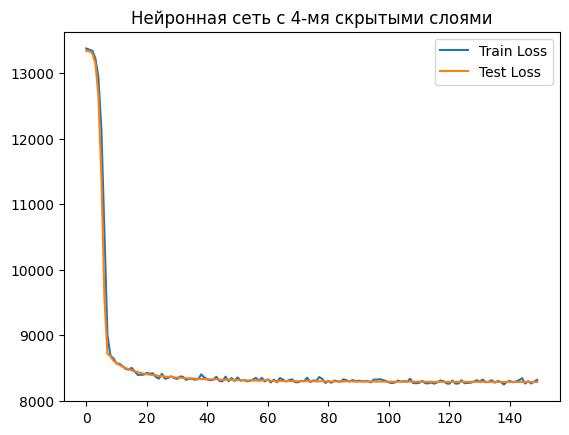

In [ ]:
# Вычислить Loss на trai и test множествах, в зависимости от эпохи обучения - learning curve
# с) Нейросеть с 4-мя скрытыми слоями с оптимизатором Adam

model = FourHiddenNetwork(X_train.shape[1], 64, 1)
# MAE loss
criterion = nn.L1Loss()
epoch = 150
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters())

train_losses, test_losses = [], []

for i in range(epoch):
  train_loss = 0.0
  for X_train, y_train in train_dataloader:
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
  test_loss = 0.0
  for X_test, y_test in test_dataloader:
    model.eval()
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    test_loss += loss.item()
  print(f"Epoch {i+1}, Loss_train: {train_loss / len(train_dataloader):.4f}, Loss_test: {test_loss / len(test_dataloader):.4f}")
  train_losses.append(train_loss / len(train_dataloader))
  test_losses.append(test_loss / len(test_dataloader))

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Нейронная сеть с 4-мя скрытыми слоями')
plt.legend()
plt.show()

7. Посчитать метрики на train и test множествах: для задачи регрессии -- MAE
* C. Нейросеть с 4-мя скрытыми слоями и оптимизатором Adam

In [ ]:
# Посчитать метрики на train и test множествах
# с) Нейросеть с 4-мя скрытыми слоями с оптимизатором Adam
from sklearn.metrics import mean_absolute_error

model = FourHiddenNetwork(X_train.shape[1], 64, 1)
def evaluate_model(model, loader):
  model.eval()
  true_values = []
  pred_values = []
  with torch.no_grad():
    for X_train, y_train in train_dataloader:
      pred = model(X_train)
      true_values.extend(y_train.numpy())
      pred_values.extend(pred.numpy().flatten())
  mae = mean_absolute_error(true_values, pred_values)
  return mae

train_mae = evaluate_model(model, train_dataloader)
test_mae = evaluate_model(model, test_dataloader)
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train MAE: 13346.1025
Test MAE: 13346.1025


8. Сравнить метрики относительно train/test и относительно разных моделей.
* А. Какая модель справилась лучше с поставленной задачей?  
Нейросеть с 4-мя скрытыми слоями справилась лучше с прогнозированием charges.
* B. Имеет ли место переобучение?  
Моедель с 4-мя скрытыми слоями демонстрируют признаки переобучения, так как значение средней абсолютной ошибки для тренировочных данных больше, чем для тестовых: Train MAE < Test Mae.
* C. Имеет ли место недообучение?  
Все модели могут аппроксимировать данные на достаточном уровне.
* D. Как можно улучшить метрики моделей?  
Для улучшения метрик моделей можно изменить архитектуру сети: количество слоев, нейронов, активиационную функцию; изменить параметры: learning_rate, batch size; использовать другие функции нормализации данных: MinMaxScaling или RobustScaling для численных признаков, OneHotEncoding или TargetEncoding для категориальных признаков; использовать иные методы оптимизации нейронных сетей; увеличить размер обучающей выборки.
